To calculate the potential for yearly CO2 reduction for San Francisco cabs, we first need to think of an efficient cabs to client dispaching system.

Below we build a dispaching system that minimize the driving distance between cabs and clients. Here we assume that all cabs are responding to a centralized dispaching system. To check system performances we simulate multiple use cases. In each use case a certain number of cabs and requestors are placed in random positions of the city. Positions are selected according to the historical data provided.

The reduction in CO2 emmission is then computed comparing the performances of the optimized system and the historical performances.

Note that no seed is set.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
import numpy as np
import random as rnd
import time as tm
import statistics as st
#import googlemaps
#import geopy.distance

# Third party imports
from scipy.optimize import linear_sum_assignment
from scipy.stats import gamma
from itertools import tee

# Local application imports
from lib import *

In [2]:
# Function to randomly sample coordinates from a uniform distribution
def sample_coordinate( cabs_data, day, hour, pickup, n_samples):
    """
    Sampling of location coordinates from data using a uniform distribution
    """
    # Uniform random sampling of location coordinates
    tf = np.logical_and(cabs_data['day']==day, cabs_data['hour']==hour)
    
    if pickup == True:
        tf1 = np.logical_and(tf, cabs_data['pick_up']==1)
    else:
        tf1 = np.logical_and(tf, cabs_data['occupancy']==0)
    
    idx = rnd.sample(range(0, tf1.sum()), n_samples)
    geo_coord = cabs_data[tf1].iloc[idx][['latitude', 'longitude']]
    
    return geo_coord;

In [3]:
def build_cost_mat(coord1, coord2):
    """
    Build a cost matrix (based on geo distances) from 
    all pairs of location coordinates in input
    """
    distances = []
    for index1, row1 in coord1.iterrows():
        for index2, row2 in coord2.iterrows():
            distances.append(haversine(row1["longitude"], row1["latitude"], 
                                       row2["longitude"], row2["latitude"]))
        
    cost_matrix = np.ndarray(shape=(len(coord1), len(coord2)), 
                             buffer=np.array(distances))
    return cost_matrix;

In [4]:
def simulate_cost(cabs_data, day, hour, ncabs, nrequests, dist_parking):
    """
    Simulate the total cost for dispaching cabs.
    Cabs and pick up locations are sampled according to the
    statistics inferred from the data in input.
    Cost is computed by minimizing distances between cabs and pick up
    locations (assignment problem). Locations of clients are assumed 
    to be the pick up locations from the input data.
    """
    coord1 = sample_coordinate(cabs_data, day, hour, False, ncabs)
    coord2 = sample_coordinate(cabs_data, day, hour, True, nrequests)
    cost_matrix = build_cost_mat(coord1, coord2)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    cost = cost_matrix[(row_ind,col_ind)].sum()
    # Add penality
    penalty = gamma.rvs(a=dist_parking, size=len(row_ind)).sum()
    return cost+penalty;

In [5]:
def simulate_scenario(ncabs_tab, pickup_tab, penalty, nsimul):
    """
    Simulate nsimul scenario. Each scenario is a snapshot of the city cabs and requests locations.
    """
    tot_cabs = []
    tot_requests = []
    tot_costs = []
    for k in range(0, nsimul):
        start = tm.time()
        day = rnd.randint(0, 6)
        hour = rnd.randint(0, 23)

        ncabs = ncabs_tab[day][hour]
        nrequests = pickup_tab[day][hour]

        tot_requests.append(nrequests)
        tot_cabs.append(ncabs)
        tot_costs.append(simulate_cost(cabs_data, day, hour, ncabs, nrequests, penalty))
        end = tm.time()
    #    print(k, end-start)
    return tot_cabs, tot_requests, tot_costs


In [6]:
## Load and format input data
cabs_data = load_data('cabspottingdata')
cabs_data = format_data(cabs_data)
#Compute and check distribution of elapsed time between consecutive signals
cabs_data['time_elapsed'] = cabs_data.groupby('cab_name')['timestamp'].diff()
cabs_data.to_csv(path_or_buf="./processed_data/cabs_data.csv")

#cabs_data = pd.read_csv("./processed_data/cabs_data.csv") #load preformatted tab

The following code computes the elapsed time between consecutive signals. The histogram shows that the gap between consecutive signals on 80% of the cases is about 64s. So we know that in a range of 64 seconds, 80% of the cabs have sent their location. This information can be used to more accurately simulate a dispaching scenario.

Text(0, 0.5, '')

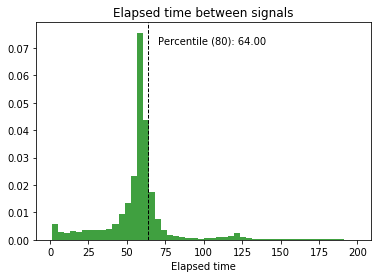

In [7]:
# Check distribution of elapsed time between consecutive signals
top_percentile = np.nanpercentile(cabs_data['time_elapsed'], 80)
# Generate histogram
time_elapsed = cabs_data['time_elapsed']
time_elapsed = time_elapsed[np.logical_and(~np.isnan(time_elapsed), time_elapsed<200)]
n, bins, patches = plt.hist(time_elapsed, 50, density=True, facecolor='g', alpha=0.75)
plt.axvline(top_percentile, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(top_percentile*1.1, max_ylim*0.9, 'Percentile (80): {:.2f}'.format(top_percentile))
plt.title('Elapsed time between signals')
plt.xlabel('Elapsed time')
plt.ylabel('')

The chunck of code below extract two additional information to simulate dispaching scenario: (1) the number of cabs that are cuncurrently in service, and (2) the number of requests in the time window defined above. Note that we overestimate the requests ot a unit. Meaning that the mileage saving will be underestimated.

In [8]:
# Use day of the month to avoid counting cabs or summing pick ups from different days

# Build ndarray with ncabs per hour per day
n_cabs = cabs_data.groupby(by=['dayofmonth', 'day', 'hour'])['cab_name'].nunique().reset_index()
n_cabs = n_cabs.groupby(by=['day', 'hour'])['cab_name'].mean().round().reset_index()
ncabs_tab = np.ndarray(shape=(7, 24), buffer=n_cabs['cab_name'].values).astype(int)

# ndarray with ncabs and avg pickup per hour per day
n_pickup = cabs_data.groupby(by=['dayofmonth', 'day', 'hour'])['pick_up'].sum().reset_index()
n_pickup = n_pickup.groupby(by=['day', 'hour'])['pick_up'].mean().reset_index()
n_pickup = (n_pickup.pick_up/3600*top_percentile).values
pickup_tab = np.ndarray(shape=(7, 24), buffer=n_pickup).astype(int) + 1

Below we compute the average roaming miles per pick up (distance drove by not occupied cabs). Note that this value includes the miles needed to pickup customers after the call. The distribution of those values is unknown, and cannot be estimated from the data in input. 

In [9]:
# Average roamning miles per single pick up
miles_per_pickup = cabs_data[cabs_data['occupancy'] == 0].miles.sum()/cabs_data.pick_up.sum()

Let's simulate some dispaching scenario while keeping track of number of cabs and requests for each simulation. 
To have a more realistic comparison, we have added a penality in the cost matrix. This penality reflects the distance between a drop off location and the next cab parking spot. We have used a gamma distribution following the assumption that it is unlikely for a cab to park at the drop off location, and it is likely to find a spot nearby (cabs are moving customers within the downtown edges). 
Here we assume that, after a drop off, cabs will drive on average 1/4 of a mile before finding a parking spot.

In [10]:
# Simulate scenario - will take > 10 minutes or reduce simulations to 100
tot_cabs, tot_requests, tot_costs = simulate_scenario(ncabs_tab, pickup_tab, 1, 1000)

The number of miles drove per pickup (2.7mi) is on average a San Francisco cab had to drive to fulfill a request in the period: May 17 - June 10, 2008.

The histogram reports instead the results of our simulation. This correspond to the number of miles needed to fullfill a request if a centralized and optimized system was in place (same period of time). In blue the 99th percentile.

Text(0, 0.5, '')

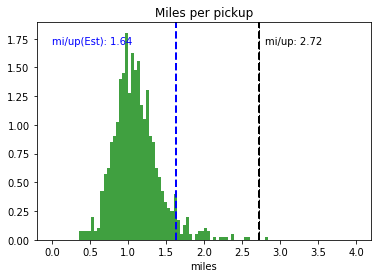

In [11]:
# Miles per pick up from simulation
miles_per_pickup_est = [x/y for x, y in zip(tot_costs, tot_requests)]

n, bins, patches = plt.hist(miles_per_pickup_est, 100, range=[0, 4], density=True, facecolor='g', alpha=0.75)
plt.axvline(miles_per_pickup, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()

plt.axvline(miles_per_pickup, color='k', linestyle='dashed', linewidth=2)
plt.text(miles_per_pickup*1.03, max_ylim*0.9, 'mi/up: {:.2f}'.format(miles_per_pickup), fontsize=10)

miles_per_pickup_est_perc = np.nanpercentile(miles_per_pickup_est, 95)
plt.axvline(miles_per_pickup_est_perc, color="b", linestyle='dashed', linewidth=2)
plt.text(0, max_ylim*0.9,
         'mi/up(Est): {:.2f}'.format(miles_per_pickup_est_perc), fontsize=10, color="b")

plt.title('Miles per pickup')
plt.xlabel('miles')
plt.ylabel('')

Below we compute the total reducion in CO2 emissions per year assuming a cab fleet transition to electical engines (10% per month). 

In other words, in one year we won't emit a volume of CO2 > 1% of the total volume occupied by single family houses in San Francisco.

In [12]:
# Total pickups per month
tot_pickups = cabs_data.pick_up.sum()
tot_pickups_per_sec = tot_pickups/(cabs_data.timestamp.max()-cabs_data.timestamp.min())
tot_pickups_per_month = tot_pickups_per_sec*2628000

# Additional miles per month 
addit_miles_per_pickup = miles_per_pickup-miles_per_pickup_est_perc
addit_miles_per_month = tot_pickups_per_month*addit_miles_per_pickup

# Reduction in CO2 emission per year (grams)
year_reduction = ((addit_miles_per_month*404)*(np.arange(90, -1, -10)/100)).sum()
print("Yearly reduction of CO2 emissions:", year_reduction.astype(int), "grams.")

Yearly reduction of CO2 emissions: 1162302441 grams.
